# Data

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt

# Plot styling
plt.rcParams['figure.dpi'] = 200
plt.rcParams['savefig.dpi'] = 200
plt.style.use('ggplot')
plt.rcParams['font.size'] = 10
plt.rcParams['axes.titlesize'] = 16
plt.rcParams["legend.edgecolor"] = 'black'
plt.rcParams["legend.fontsize"] = 11

# 1. Explore Word Embeddings

### a. Build Your Own Data Set of Words (5pts)

In [2]:
from GloVe_Embedder import GloVe_Embedder

def buildData():
    GV_embedded = GloVe_Embedder("GloVe_Embedder_data.txt")
    seed_words = ["flight", "good", "terrible", "help", "late"]

    d150embd = [] # build data set of word vectors
    d150wrds = [] # build data set of words (raw)

    seed_words_embeddings = GV_embedded.embed_list(seed_words)
    clusterNum = 1

    for word in seed_words:
        embedding = GV_embedded.embed_str(word)
        d150embd.append(embedding) # append embedding of words
        d150wrds.append([word, int(clusterNum)]) # append word & cluster number (used for graphing)
        cluster = GV_embedded.find_k_nearest(embedding, 29)
        print(word, "cluster:")

        for w in cluster:
            print("\t", w[0], w[1])
            d150embd.append(GV_embedded.embed_str(w[0])) # append embedding of current words
            d150wrds.append([w[0], int(clusterNum)]) # append word & cluster number (used for graphing)
        clusterNum += 1
        print()

    return d150embd, d150wrds

In [3]:
d150embd, d150wrds = buildData()

flight cluster:
	 flight 0.0
	 plane 4.45689
	 flights 5.32675
	 boarding 5.4882
	 airline 5.58355
	 jet 5.59065
	 flying 5.59299
	 heading 5.6417
	 arrival 5.70659
	 airlines 5.85213
	 travel 5.89098
	 shuttle 5.90023
	 delayed 5.91624
	 landing 5.92666
	 route 5.96298
	 airplane 6.00258
	 safe 6.00877
	 booking 6.01374
	 fly 6.02409
	 departure 6.04052
	 waiting 6.04259
	 landed 6.09697
	 journey 6.12156
	 passengers 6.12345
	 transit 6.12451
	 delay 6.13663
	 crew 6.14757
	 pilot 6.17311
	 trip 6.18669

good cluster:
	 good 0.0
	 great 3.64107
	 well 3.96383
	 nice 4.00469
	 better 4.19665
	 night 4.30113
	 bad 4.34788
	 morning 4.43596
	 way 4.52146
	 hope 4.54451
	 but 4.55671
	 too 4.57775
	 really 4.60558
	 right 4.68877
	 though 4.69955
	 there 4.70148
	 day 4.70444
	 luck 4.7177
	 sure 4.76147
	 it 4.76949
	 thing 4.78543
	 pretty 4.81795
	 think 4.83542
	 have 4.84457
	 all 4.85276
	 yes 4.86179
	 very 4.89081
	 again 4.9018
	 work 4.90492

terrible cluster:
	 terrible 0.0
	 

### b. Dimension Reduction and Visualization (25pts)

In [4]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_2d = pca.fit_transform(d150embd)

### c. Clustering (20pts)

In [6]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

val_df = pd.DataFrame(data={"embeddings":d150embd, "baseWord": d150wrds[:,0], "cluster":d150wrds[:,1]})

purityScore = []
randScore = []
inertiaScore = []
mutualInfoScore = []

kRange = [x for x in range(2,21)]

for k in kRange:
    kmeans = KMeans(n_clusters=k).fit(d150embd)
    predsLabels = kmeans.labels_
    purityScore.append(None) # Need to implement this
    randScore.append(adjusted_rand_score(d150wrds[:,1], predsLabels))
    inertiaScore.append(kmeans.inertia_)
    mutualInfoScore.append(normalized_mutual_info_score(d150wrds[:,1], predsLabels))

TypeError: list indices must be integers or slices, not tuple

In [ ]:
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.plot(kRange, randScore)
plt.title("Rand Score")
plt.subplot(2,2,2)
plt.plot(kRange, inertiaScore)
plt.title("Inertia")
plt.subplot(2,2,3)
plt.plot(kRange, mutualInfoScore)
plt.title("Mutual Info Score")
#plt.subplot(2,2,4)
#plt.plot(kRange, purityScore)
#plt.title("Purity Score")
plt.show()

In [ ]:
# Not required but thought it could be interesting to see the difference of how they were clustered
# Below is PCA but colored by the labels from kmeans clusters
plt.figure(figsize=(8,8))
plt.subplot(2,1,1)
scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], 
                      c=np.asarray(GV_label[:,1], dtype=int), cmap="Set1")
plt.legend(handles=scatter.legend_elements()[0], labels=seed_words)
plt.title("PCA colored by Kmeans")
plt.ylabel("d2")
plt.xlabel("d1")
plt.show()

plt.figure(figsize=(8,8))
plt.subplot(2,1,2)
kTmp = KMeans(n_clusters=8).fit(GV_emb)
scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=kTmp.labels_, cmap="Set1")
plt.legend(handles=scatter.legend_elements()[0], labels=list(np.arange(0,8)))
plt.title("PCA colored by Kmeans")
plt.ylabel("d2")
plt.xlabel("d1")
plt.show()

# 2. Using Word Embeddings to Improve Classification

In [51]:
df_train = pd.read_csv("IA3-train.csv")
df_val = pd.read_csv("IA3-dev.csv")

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidfvectorizer = TfidfVectorizer(use_idf=True, lowercase=True)

X_train_tfid = tfidfvectorizer.fit_transform(df_train['text'])
# X_train = df_train['text']
y_train_tfid = df_train['sentiment']

X_val_tfid = tfidfvectorizer.transform(df_val['text']).toarray()
y_val_tfid = df_val['sentiment']

### Approach 1: weighted average of the embeddings

In [16]:
GV_embedder = GloVe_Embedder("GloVe_Embedder_data.txt")

def average_embeddings(sentence):
    emb = GV_embedder.embed_list(sentence.split())
    return emb.sum(axis=0) / len(emb)

X_train_aemb = []
for tweet in df_train['text']:
    avg_emb = average_embeddings(tweet)
    X_train_aemb.append(avg_emb)
    
X_val_aemb = []
for tweet in df_val['text']:
    avg_emb = average_embeddings(tweet)
    X_val_aemb.append(avg_emb)

In [17]:
df_X_train_aemb = pd.DataFrame(X_train_aemb)
# df_X_train_aemb = pd.concat([df_train, df_X_train_aemb], axis = 1)
y_train = df_train['sentiment']

df_X_val_aemb = pd.DataFrame(X_val_aemb)
# df_X_val_aemb = pd.concat([df_val, df_X_val_aemb], axis = 1)
y_val = df_val['sentiment']

In [18]:
from sklearn.svm import SVC

def trainSVM(X_train, y_train, X_val, y_val, c, kernel, deg=3):
    """
    Description: scikit learn linearSVC wrapper
    Param:
        X_train  [in]: training data
        y_train  [in]: training label
        X_val    [in]: validation data
        y_val    [in]: validation label
        c        [in]: Regularization parameter. The strength of the 
                       regularization is inversely proportional to C. Must be 
                       strictly positive.
        kernel   [in]: Kernel type for SVC
        deg      [in]: degree (only for poly kernel) - if not poly, this is 
                       ignored (default param set to sklearn default = 3)
    Return: training accuracy, validation accuracy, and number of SV's (respectively)
    """
    n_train = X_train.shape[0]
    n_val = X_val.shape[0]
    
    svm = SVC(C=c, kernel=kernel, degree=deg, max_iter=25000)
    svm.fit(X_train, y_train)
    
    y_pred_train = svm.predict(X_train)
    y_pred_val = svm.predict(X_val)
    
    acc_train = (n_train - np.count_nonzero(y_pred_train - y_train)) / n_train
    acc_val = (n_val - np.count_nonzero(y_pred_val - y_val)) / n_val
    
    return acc_train, acc_val, svm.n_support_

# Define initial c values
cVals = [10**i for i in range(-4,5)]

acc_train = {}
acc_val = {}
nSVs = {}
    
for c in cVals:
    print("Training on c =", c)
    acc_train[c], acc_val[c], nSVs[c] = trainSVM(df_X_train_aemb, y_train, df_X_val_aemb, y_val, c, "linear")

Training on c = 0.0001
Training on c = 0.001
Training on c = 0.01
Training on c = 0.1
Training on c = 1
Training on c = 10


/Users/johnnybui/opt/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=25000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Training on c = 100


/Users/johnnybui/opt/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=25000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Training on c = 1000


/Users/johnnybui/opt/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=25000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Training on c = 10000


/Users/johnnybui/opt/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=25000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


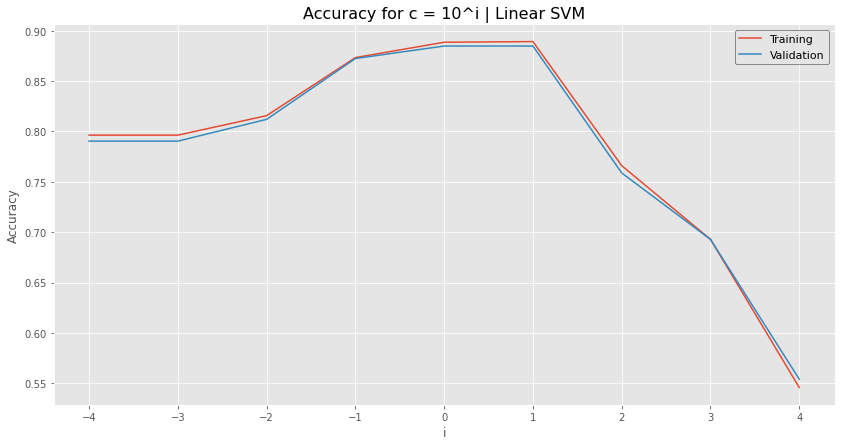

In [19]:
def plotAcc(exp, tAcc, vAcc, title, pName):
    '''
    Plot the accuracy for train and validation data set for SVM
    '''
    fig = plt.figure(figsize=(14,7))
    plt.plot(exp, list(tAcc.values()), label="Training")
    plt.plot(exp, list(vAcc.values()), label="Validation")
    
    plt.xlabel("i")
    plt.ylabel("Accuracy")
    plt.title("Accuracy for c = 10^i | " + title)
    plt.legend()
    plt.savefig(pName)
    return

xrange = range(-4,5)
plotAcc(xrange, acc_train, acc_val, "Linear SVM", "lsvmAcc.jpg")

In [20]:
print(acc_val)

{0.0001: 0.7904, 0.001: 0.7904, 0.01: 0.812, 0.1: 0.8724, 1: 0.8848, 10: 0.8848, 100: 0.7588, 1000: 0.6928, 10000: 0.554}


#### Using Gensim

In [ ]:
import gensim
from collections import defaultdict

model = gensim.models.Word2Vec(X, size=100)
w2v = dict(zip(model.wv.index2word, model.wv.syn0))

class TfidfEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.word2weight = None
        self.dim = len(word2vec.itervalues().next())

    def fit(self, X, y):
        tfidf = TfidfVectorizer(analyzer=lambda x: x)
        tfidf.fit(X)
        # if a word was never seen - it must be at least as infrequent
        # as any of the known words - so the default idf is the max of 
        # known idf's
        max_idf = max(tfidf.idf_)
        self.word2weight = defaultdict(
            lambda: max_idf,
            [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])

        return self

    def transform(self, X):
        return np.array([
                np.mean([self.word2vec[w] * self.word2weight[w]
                         for w in words if w in self.word2vec] or
                        [np.zeros(self.dim)], axis=0)
                for words in X
            ])

### Approach 2: Cluster the words in the vocabulary and represent each tweet using bag-of-word-clusters

### Approach 3: Improve utilization of the GloVe embeddings

In [34]:
GV_embedder.vocab_size

GV_embedder.embed_str("")

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:
# from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

# def make_embedding_matrix(train_samples, val_samples, embeddings_index):
#     """
#     This function computes the embedding matrix that will be used in the embedding layer
    
#     Parameters:
#         train_samples: list of strings in the training dataset
#         val_samples: list of strings in the validation dataset
#         embeddings_index: Python dictionary with word embeddings
    
#     Returns:
#         embedding_matrix: embedding matrix with the dimensions (num_tokens, embedding_dim), where num_tokens is the vocabulary of the input data, and emdebbing_dim is the number of components in the GloVe vectors (can be 50,100,200,300)
#         vectorizer: TextVectorization layer      
#     """
#      vectorizer = TextVectorization(max_tokens=30000, output_sequence_length=50)
#     text_ds = tf.data.Dataset.from_tensor_slices(train_samples).batch(128)
#     vectorizer.adapt(text_ds)
    
#     voc = vectorizer.get_vocabulary()
#     word_index = dict(zip(voc, range(len(voc))))
      
#     num_tokens = len(voc)
    
#     hits = 0
#     misses = 0

# #   creating an embedding matrix
#     embedding_dim = len(embeddings_index['the'])
#     embedding_matrix = np.zeros((num_tokens, embedding_dim))
#     for word, i in word_index.items():
#         embedding_vector = embeddings_index.get(word)
#         if embedding_vector is not None:
#             # Words not found in embedding index will be all-zeros
#             embedding_matrix[i] = embedding_vector
#             hits += 1
#         else:
#             misses += 1
# #     print("Converted %d words (%d misses)" % (hits, misses))
#     print(f"Converted {hits} words ({misses} misses).")

#     return embedding_matrix, vectorizer

### Approach 4: Clean the tweets

In [71]:
from gensim.models import Word2Vec

import re
from string import punctuation

from nltk.tokenize import word_tokenize


df_train = pd.read_csv("IA3-train.csv")
df_val = pd.read_csv("IA3-dev.csv")

# Adapted from https://www.kaggle.com/code/artemzapara/twitter-feeds-classification-with-glove-embeddings/notebook
def clean_text(text):
    text = text.lower() # lowercase
    text = re.sub('@\w+ ', ' ', text)    # Remove "@..." which are not related to the sentiment
    text = re.sub('[%s]' % re.escape(punctuation), '', text) # Remove punctuation
    return text

df_train_clean = df_train
df_val_clean = df_val

# Applying the cleaning function to both test and train datasets
df_train_clean['text'] = df_train['text'].apply(lambda x: clean_text(x))
df_val_clean['text'] = df_val['text'].apply(lambda x: clean_text(x))

df_train_clean.to_csv("clean_tweet.csv")

X_train_aemb = []
tweet_vocab = set()
for tweet in df_train_clean['text']:
    new_vocab = set(tweet.split())
    avg_emb = average_embeddings(tweet)
    X_train_aemb.append(avg_emb)
    tweet_vocab = tweet_vocab.union(new_vocab)
    
X_val_aemb = []
for tweet in df_val_clean['text']:
    avg_emb = average_embeddings(tweet)
    X_val_aemb.append(avg_emb)

In [70]:
import csv

with open("tweets_emb.csv", "w") as f:
    writer = csv.writer(f)
    writer.writerows(X_train_aemb)

In [74]:
# Find vocabulary of the tweets
with open("tweets_vocab.txt", "w") as f:
    f.write(tweet_vocab)

# tweet_vocab


TypeError: write() argument must be str, not set

In [68]:
for c in cVals:
    print("Training on c =", c)
    acc_train[c], acc_val[c], nSVs[c] = trainSVM(df_X_train_aemb, y_train, df_X_val_aemb, y_val, c, "linear")

Training on c = 0.0001
Training on c = 0.001
Training on c = 0.01
Training on c = 0.1
Training on c = 1
Training on c = 10


/Users/johnnybui/opt/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=25000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Training on c = 100


/Users/johnnybui/opt/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=25000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Training on c = 1000


/Users/johnnybui/opt/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=25000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Training on c = 10000


/Users/johnnybui/opt/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=25000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


{0.0001: 0.7904, 0.001: 0.7904, 0.01: 0.812, 0.1: 0.8724, 1: 0.8848, 10: 0.8848, 100: 0.7588, 1000: 0.6928, 10000: 0.554}


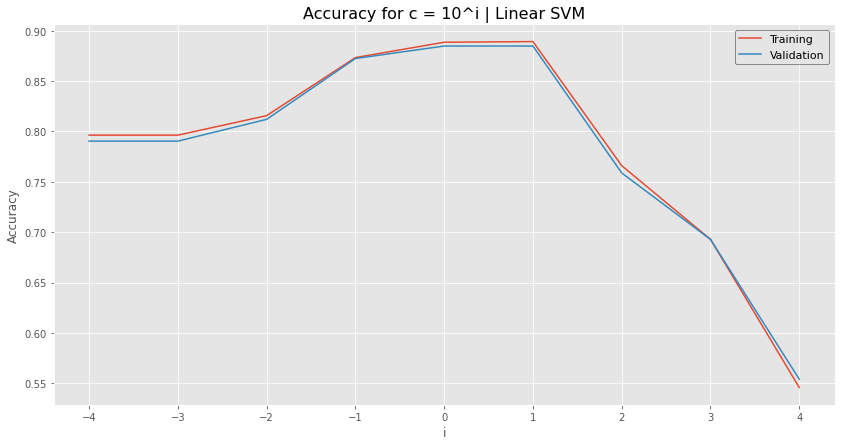

In [66]:
print(acc_val)
plotAcc(xrange, acc_train, acc_val, "Linear SVM", "lsvmAcc.jpg")

### Visualize

In [ ]:
pca = PCA(n_components=2)
X_2d = pca.fit_transform(d150embd)
d150wrds = np.asarray(d150wrds)
plot_2d_cluster(X_2d, d150wrds, "PCA on 150 Clustered Words")